# Predicting IMDS Using Satellite Embeddings with Optuna Hyperparameter Tuning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/ds4bolivia/blob/master/notebooks/predict_imds_rf_optuna.ipynb)

## Overview

This notebook extends our baseline IMDS prediction model by incorporating **Optuna**, a state-of-the-art hyperparameter optimization framework. While our baseline model used fixed hyperparameters, this notebook demonstrates how automated hyperparameter tuning can potentially improve model performance.

### What You Will Learn

1. **Hyperparameter Optimization Fundamentals**: Understanding why and how we tune model parameters
2. **Optuna Framework**: Using Optuna for efficient Bayesian optimization
3. **Study Design**: Creating optimization studies with objectives and search spaces
4. **Visualization**: Interpreting optimization history and parameter importance
5. **Best Practices**: Avoiding overfitting during hyperparameter search

### Prerequisites

Before starting this notebook, you should be familiar with:
- Basic machine learning concepts (training, validation, testing)
- Random Forest algorithms
- Cross-validation techniques

If you're new to these concepts, we recommend first completing the baseline notebook: [predict_imds_rf.ipynb](https://colab.research.google.com/github/quarcs-lab/ds4bolivia/blob/master/notebooks/predict_imds_rf.ipynb)

---

## Why Hyperparameter Tuning?

### The Problem with Default Parameters

Machine learning models have two types of parameters:

1. **Model Parameters**: Learned from data during training (e.g., tree splits in Random Forest)
2. **Hyperparameters**: Set before training and control the learning process (e.g., number of trees, max depth)

Default hyperparameters are designed to work "reasonably well" across many datasets, but they're rarely optimal for your specific problem. Hyperparameter tuning finds the best configuration for your data.

### Why Optuna?

Traditional approaches like Grid Search test every combination (slow) or Random Search samples randomly (inefficient). **Optuna** uses **Bayesian optimization** which:

- **Learns from previous trials**: Uses past results to suggest promising hyperparameters
- **Prunes unpromising trials**: Stops bad configurations early, saving computation
- **Handles complex search spaces**: Works with continuous, discrete, and conditional parameters

```
Grid Search:     [■][■][■][■][■][■][■][■][■]  → Tests ALL combinations
Random Search:   [■][ ][■][ ][ ][■][ ][■][ ]  → Random sampling
Optuna:          [■]→[■]→→→[■]→→→→→→[★]       → Smart, directed search
```

---

## 1. Environment Setup

First, we install Optuna and import all required libraries. In Google Colab, Optuna is not pre-installed, so we need to install it first.

In [1]:
# =============================================================================
# INSTALL OPTUNA
# =============================================================================
# Optuna is not included in the default Colab environment, so we install it.
# The -q flag suppresses verbose output for cleaner notebooks.

!pip install -q optuna

print("Optuna installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.7 MB/s eta 0:00:00
Optuna installed successfully!


In [2]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

# Data manipulation and numerical computing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,    # Split data into train/test sets
    cross_val_score,     # Perform cross-validation
    KFold                # K-Fold cross-validation splitter
)
from sklearn.metrics import (
    mean_squared_error,  # MSE metric
    mean_absolute_error, # MAE metric
    r2_score             # R² coefficient of determination
)

# Hyperparameter optimization
import optuna
from optuna.visualization import (
    plot_optimization_history,      # Track optimization progress
    plot_param_importances,         # Which hyperparameters matter most
    plot_contour,                   # 2D parameter relationships
    plot_slice                      # 1D parameter effects
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Optuna logging - set to WARNING to reduce verbosity during optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)

# =============================================================================
# REPRODUCIBILITY
# =============================================================================
# Setting random seeds ensures that results are reproducible.
# This is crucial for scientific work and debugging.

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Optuna version: {optuna.__version__}")
print("All libraries imported successfully!")

Optuna version: 4.6.0
All libraries imported successfully!


## 2. Data Loading and Preparation

We load the same datasets as in the baseline notebook:
- **SDG Data**: Contains IMDS (our target variable)
- **Satellite Embeddings**: 64 features derived from satellite imagery
- **Region Names**: Municipality names for interpretation

### About the IMDS

The **IMDS (Índice Municipal de Desarrollo Sostenible)** is a composite index that aggregates all SDG indicators into a single score (0-100). It represents overall sustainable development at the municipal level in Bolivia.

In [3]:
# =============================================================================
# DATA LOADING
# =============================================================================
# We load data directly from the DS4Bolivia GitHub repository.
# This ensures reproducibility - anyone can run this notebook.

REPO_URL = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master"

# Define data URLs
url_sdg = f"{REPO_URL}/sdg/sdg.csv"                                    # SDG indices (target)
url_emb = f"{REPO_URL}/satelliteEmbeddings/satelliteEmbeddings2017.csv" # Satellite features
url_names = f"{REPO_URL}/regionNames/regionNames.csv"                   # Municipality names

# Load datasets
print("Loading datasets from GitHub...")
df_sdg = pd.read_csv(url_sdg)
df_embeddings = pd.read_csv(url_emb)
df_names = pd.read_csv(url_names)

print(f"✓ SDG data: {len(df_sdg)} municipalities")
print(f"✓ Satellite embeddings: {len(df_embeddings)} municipalities, {len(df_embeddings.columns)-1} features")
print(f"✓ Region names: {len(df_names)} municipalities")

Loading datasets from GitHub...
✓ SDG data: 339 municipalities
✓ Satellite embeddings: 339 municipalities, 64 features
✓ Region names: 339 municipalities


In [4]:
# =============================================================================
# DATA MERGING
# =============================================================================
# We merge all datasets using 'asdf_id' as the common key.
# This creates a single dataframe with target, features, and names.

# Step 1: Merge SDG data (with IMDS target) with satellite embeddings
df_merged = df_sdg[['asdf_id', 'imds']].merge(
    df_embeddings,
    on='asdf_id',
    how='inner'  # Keep only municipalities present in both datasets
)

# Step 2: Add municipality and department names for interpretation
df_merged = df_merged.merge(
    df_names[['asdf_id', 'mun', 'dep']],
    on='asdf_id',
    how='left'
)

# Step 3: Remove any rows with missing IMDS values
df_clean = df_merged.dropna(subset=['imds']).copy()

print(f"Merged dataset: {len(df_clean)} municipalities")
print(f"Columns: {len(df_clean.columns)} total")

Merged dataset: 339 municipalities
Columns: 68 total


In [5]:
# =============================================================================
# FEATURE AND TARGET PREPARATION
# =============================================================================
# We separate our data into:
# - X (features): The 64 satellite embedding dimensions (A00 to A63)
# - y (target): The IMDS score we want to predict

# Create list of feature column names (A00, A01, ..., A63)
embedding_cols = [f'A{str(i).zfill(2)}' for i in range(64)]

# Extract feature matrix and target vector
X = df_clean[embedding_cols].values  # Shape: (n_samples, 64)
y = df_clean['imds'].values          # Shape: (n_samples,)

print("Data prepared for modeling:")
print(f"  Features (X): {X.shape[0]} samples × {X.shape[1]} features")
print(f"  Target (y): {y.shape[0]} samples")
print(f"\nIMDS Statistics:")
print(f"  Range: [{y.min():.2f}, {y.max():.2f}]")
print(f"  Mean ± Std: {y.mean():.2f} ± {y.std():.2f}")

Data prepared for modeling:
  Features (X): 339 samples × 64 features
  Target (y): 339 samples

IMDS Statistics:
  Range: [35.70, 80.20]
  Mean ± Std: 51.05 ± 6.76


## 3. Train-Validation-Test Split Strategy

### Why Three Sets?

When doing hyperparameter tuning, we need to be careful about data leakage:

| Set | Purpose | Used During |
|-----|---------|-------------|
| **Training** | Fit model parameters | Each trial |
| **Validation** | Evaluate hyperparameters | Optimization |
| **Test** | Final unbiased evaluation | Only once, at the end |

```
┌─────────────────────────────────────────────────────────────┐
│                     Full Dataset (339)                       │
├─────────────────────────────────────────────┬───────────────┤
│           Training + Validation (271)       │   Test (68)   │
│  ┌─────────────────────┬──────────────────┐ │               │
│  │ Train (CV Folds)    │ Val (CV Folds)   │ │  Final Eval   │
│  │ Used by Optuna      │ Used by Optuna   │ │  Held Out     │
│  └─────────────────────┴──────────────────┘ │               │
└─────────────────────────────────────────────┴───────────────┘
```

**Important**: The test set is NEVER used during hyperparameter tuning. It provides an unbiased estimate of final model performance.

In [6]:
# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================
# We hold out 20% of the data as a final test set.
# The remaining 80% will be used for training and cross-validation.

X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test = train_test_split(
    X,
    y,
    df_clean.index,  # Keep track of original indices for later analysis
    test_size=0.2,   # 20% for final testing
    random_state=RANDOM_STATE  # Reproducibility
)

print("Data Split Summary:")
print(f"  Training + Validation: {len(X_train_val)} municipalities ({len(X_train_val)/len(X)*100:.1f}%)")
print(f"  Test (held out):       {len(X_test)} municipalities ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nNote: Optuna will use cross-validation on the training set.")
print(f"      The test set remains untouched until final evaluation.")

Data Split Summary:
  Training + Validation: 271 municipalities (79.9%)
  Test (held out):       68 municipalities (20.1%)

Note: Optuna will use cross-validation on the training set.
      The test set remains untouched until final evaluation.


## 4. Understanding Optuna: Core Concepts

Before we define our optimization, let's understand Optuna's key concepts:

### Key Terminology

| Term | Definition | Example |
|------|------------|--------|
| **Study** | The optimization task | "Find best Random Forest hyperparameters" |
| **Trial** | One evaluation with specific hyperparameters | n_estimators=100, max_depth=10 |
| **Objective** | Function to optimize | Cross-validation R² score |
| **Search Space** | Range of possible values | n_estimators ∈ [50, 500] |
| **Sampler** | Algorithm to suggest next trial | TPE (Tree-structured Parzen Estimator) |
| **Pruner** | Stops unpromising trials early | MedianPruner |

### How Optuna Works

```
┌─────────────────────────────────────────────────────────────┐
│  For each trial:                                            │
│                                                             │
│  1. Sampler suggests hyperparameters based on history       │
│  2. Objective function trains model with these parameters   │
│  3. Cross-validation score is computed                      │
│  4. Result is recorded for future sampling                  │
│  5. Repeat until n_trials completed                         │
│                                                             │
│  Trial 1 → Trial 2 → Trial 3 → ... → Best Parameters       │
│    ↓         ↓         ↓                                    │
│  Learn    Learn     Learn (gets smarter over time)          │
└─────────────────────────────────────────────────────────────┘
```

---

## 5. Defining the Objective Function

The **objective function** is the heart of Optuna optimization. It:
1. Receives a `trial` object from Optuna
2. Samples hyperparameters from defined search spaces
3. Trains a model with those hyperparameters
4. Returns a score to optimize (we maximize cross-validation R²)

### Search Space Design

Choosing good search spaces is crucial. We consider:
- **Physical constraints**: max_depth can't be negative
- **Computational limits**: Too many trees = slow training
- **Domain knowledge**: Typical ranges that work well

| Hyperparameter | Search Space | Rationale |
|----------------|--------------|----------|
| `n_estimators` | 50 - 500 | More trees = better but slower |
| `max_depth` | 5 - 50 | Too shallow = underfit, too deep = overfit |
| `min_samples_split` | 2 - 20 | Controls tree complexity |
| `min_samples_leaf` | 1 - 10 | Prevents tiny leaf nodes |
| `max_features` | sqrt, log2, None | Features per split |

In [7]:
# =============================================================================
# OBJECTIVE FUNCTION DEFINITION
# =============================================================================
# This function is called by Optuna for each trial.
# It samples hyperparameters, trains a model, and returns the CV score.

def objective(trial):
    """
    Optuna objective function for Random Forest hyperparameter optimization.

    Parameters:
    -----------
    trial : optuna.Trial
        Optuna trial object that suggests hyperparameter values

    Returns:
    --------
    float
        Mean cross-validation R² score (to be maximized)
    """

    # -------------------------------------------------------------------------
    # STEP 1: Sample hyperparameters from search spaces
    # -------------------------------------------------------------------------
    # trial.suggest_* methods define the search space and sample values

    # Number of trees in the forest
    # More trees generally improve performance but increase training time
    n_estimators = trial.suggest_int(
        'n_estimators',  # Parameter name (used in results)
        50,              # Minimum value
        500,             # Maximum value
        step=50          # Step size (50, 100, 150, ...)
    )

    # Maximum depth of each tree
    # Deeper trees can capture complex patterns but may overfit
    max_depth = trial.suggest_int(
        'max_depth',
        5,               # Minimum (shallow trees)
        50               # Maximum (deep trees)
    )

    # Minimum samples required to split an internal node
    # Higher values prevent overfitting by requiring more evidence for splits
    min_samples_split = trial.suggest_int(
        'min_samples_split',
        2,               # scikit-learn default
        20               # More conservative
    )

    # Minimum samples required at each leaf node
    # Prevents trees from creating leaves with very few samples
    min_samples_leaf = trial.suggest_int(
        'min_samples_leaf',
        1,               # scikit-learn default
        10               # More conservative
    )

    # Number of features to consider at each split
    # 'sqrt' and 'log2' add randomness, reducing correlation between trees
    max_features = trial.suggest_categorical(
        'max_features',
        ['sqrt', 'log2', None]  # None = use all features
    )

    # -------------------------------------------------------------------------
    # STEP 2: Create and train the model
    # -------------------------------------------------------------------------

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=RANDOM_STATE,  # Reproducibility
        n_jobs=-1                   # Use all CPU cores
    )

    # -------------------------------------------------------------------------
    # STEP 3: Evaluate using cross-validation
    # -------------------------------------------------------------------------
    # We use 5-fold CV to get a robust estimate of model performance.
    # This helps avoid overfitting to a single validation split.

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    cv_scores = cross_val_score(
        model,
        X_train_val,     # Training data (not test set!)
        y_train_val,
        cv=cv,
        scoring='r2'     # R² score (coefficient of determination)
    )

    # Return mean CV score - Optuna will try to MAXIMIZE this
    return cv_scores.mean()

print("Objective function defined successfully!")
print("\nSearch space summary:")
print("  n_estimators:      [50, 500] step=50")
print("  max_depth:         [5, 50]")
print("  min_samples_split: [2, 20]")
print("  min_samples_leaf:  [1, 10]")
print("  max_features:      ['sqrt', 'log2', None]")

Objective function defined successfully!

Search space summary:
  n_estimators:      [50, 500] step=50
  max_depth:         [5, 50]
  min_samples_split: [2, 20]
  min_samples_leaf:  [1, 10]
  max_features:      ['sqrt', 'log2', None]


## 6. Running the Optimization Study

Now we create an Optuna **study** and run the optimization. Key settings:

- **`direction='maximize'`**: We want to maximize R² (higher is better)
- **`n_trials=100`**: Number of hyperparameter combinations to try
- **`sampler=TPESampler`**: Tree-structured Parzen Estimator (Bayesian optimization)

### What Happens During Optimization?

1. Optuna suggests hyperparameters based on previous trials
2. The objective function trains a model and computes CV R²
3. Optuna records the result and updates its model
4. After all trials, we get the best hyperparameters found

**Note**: This may take several minutes depending on your hardware. With 100 trials and 5-fold CV, we're training 500 Random Forest models!

In [8]:
# =============================================================================
# CREATE AND RUN OPTUNA STUDY
# =============================================================================

# Number of optimization trials
# More trials = better chance of finding optimal parameters, but takes longer
N_TRIALS = 100

print("="*60)
print("STARTING OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*60)
print(f"\nConfiguration:")
print(f"  Number of trials: {N_TRIALS}")
print(f"  CV folds per trial: 5")
print(f"  Total models to train: {N_TRIALS * 5}")
print(f"  Objective: Maximize CV R²")
print(f"\nThis may take several minutes...\n")

# Create the study
# - direction='maximize': We want higher R² scores
# - sampler: TPE is the default and works well for most problems
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    study_name='IMDS_RandomForest_Optimization'
)

# Run the optimization
# show_progress_bar=True gives visual feedback during optimization
study.optimize(
    objective,
    n_trials=N_TRIALS,
    show_progress_bar=True
)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE!")
print("="*60)

STARTING OPTUNA HYPERPARAMETER OPTIMIZATION

Configuration:
  Number of trials: 100
  CV folds per trial: 5
  Total models to train: 500
  Objective: Maximize CV R²

This may take several minutes...



  0%|          | 0/100 [00:00<?, ?it/s]


OPTIMIZATION COMPLETE!


## 7. Analyzing Optimization Results

After optimization, we analyze:
1. **Best hyperparameters found**
2. **Optimization history**: How scores improved over trials
3. **Parameter importance**: Which hyperparameters matter most

This analysis helps us understand not just WHAT works, but WHY.

In [9]:
# =============================================================================
# BEST TRIAL ANALYSIS
# =============================================================================

# Get the best trial from the study
best_trial = study.best_trial

print("BEST HYPERPARAMETERS FOUND")
print("="*50)
print(f"\nBest CV R² Score: {best_trial.value:.4f}")
print(f"Trial Number: {best_trial.number}")
print(f"\nOptimal Hyperparameters:")
print("-"*50)

# Store best parameters for later use
best_params = best_trial.params

for param_name, param_value in best_params.items():
    print(f"  {param_name:20s}: {param_value}")

print("-"*50)

BEST HYPERPARAMETERS FOUND

Best CV R² Score: 0.2380
Trial Number: 78

Optimal Hyperparameters:
--------------------------------------------------
  n_estimators        : 150
  max_depth           : 23
  min_samples_split   : 3
  min_samples_leaf    : 4
  max_features        : None
--------------------------------------------------


In [10]:
# =============================================================================
# OPTIMIZATION HISTORY VISUALIZATION
# =============================================================================
# This shows how the optimization progressed over trials.
# The blue line shows best value found so far (should increase over time).

fig = plot_optimization_history(study)
fig.update_layout(
    title="Optimization History: CV R² Score Over Trials",
    xaxis_title="Trial Number",
    yaxis_title="CV R² Score"
)
fig.show()

In [11]:
# =============================================================================
# HYPERPARAMETER IMPORTANCE
# =============================================================================
# This shows which hyperparameters have the most impact on model performance.
# High importance = this parameter significantly affects the score.

fig = plot_param_importances(study)
fig.update_layout(
    title="Hyperparameter Importance Analysis",
    xaxis_title="Importance for CV R² Score"
)
fig.show()

In [12]:
# =============================================================================
# PARAMETER SLICE PLOTS
# =============================================================================
# These plots show how the objective value changes with each parameter.
# Helps identify optimal ranges and parameter sensitivity.

fig = plot_slice(study)
fig.update_layout(title="Parameter Effects on CV R² Score")
fig.show()

In [13]:
# =============================================================================
# TOP 10 TRIALS SUMMARY
# =============================================================================
# Looking at the top trials helps understand the "good" parameter region.

# Get trials sorted by value (descending)
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value', ascending=False)

print("TOP 10 TRIALS")
print("="*80)

# Select relevant columns
display_cols = ['number', 'value'] + [f'params_{p}' for p in best_params.keys()]
top_10 = trials_df[display_cols].head(10)

# Rename columns for clarity
top_10.columns = ['Trial', 'CV R²'] + list(best_params.keys())

print(top_10.to_string(index=False))

TOP 10 TRIALS
 Trial    CV R²  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features
    78 0.237988           150         23                  3                 4         None
    82 0.237988           150         16                  3                 4         None
    96 0.237988           150         22                  4                 4         None
    13 0.237988           150         24                  5                 4         None
    76 0.237988           150         19                  3                 4         None
    81 0.237988           150         19                  3                 4         None
    92 0.237988           150         20                  2                 4         None
    71 0.237988           150         20                  3                 4         None
    72 0.237988           150         19                  3                 4         None
    99 0.237988           150         18                  4                 

## 8. Training the Final Model with Optimal Hyperparameters

Now we train the final model using:
1. **Best hyperparameters** found by Optuna
2. **Full training data** (all 271 municipalities in train_val set)

This model will be evaluated on the held-out test set to get an unbiased performance estimate.

In [14]:
# =============================================================================
# TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS
# =============================================================================

print("Training final model with optimal hyperparameters...")
print("-"*50)

# Create final model with best parameters
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train on full training set
final_model.fit(X_train_val, y_train_val)

print("✓ Final model trained successfully!")
print(f"\nModel configuration:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Training final model with optimal hyperparameters...
--------------------------------------------------
✓ Final model trained successfully!

Model configuration:
  n_estimators: 150
  max_depth: 23
  min_samples_split: 3
  min_samples_leaf: 4
  max_features: None


## 9. Model Evaluation on Held-Out Test Set

This is the moment of truth! We evaluate our tuned model on the test set that was **never used during optimization**. This gives us an unbiased estimate of how well our model will perform on new, unseen data.

### Metrics We Use

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **R²** | 1 - (SS_res / SS_tot) | % of variance explained (0-1, higher is better) |
| **RMSE** | √(mean((y - ŷ)²)) | Average error magnitude (same units as target) |
| **MAE** | mean(\|y - ŷ\|) | Average absolute error (robust to outliers) |

In [15]:
# =============================================================================
# PREDICTIONS AND METRICS
# =============================================================================

# Make predictions on both sets
y_train_pred = final_model.predict(X_train_val)
y_test_pred = final_model.predict(X_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train_val, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_val, y_train_pred))
train_mae = mean_absolute_error(y_train_val, y_train_pred)

# Calculate metrics for test set (THE IMPORTANT ONES)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate prediction errors for later analysis
test_errors = y_test - y_test_pred

print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"\n{'Metric':<15} {'Training Set':<20} {'Test Set':<20}")
print("-"*55)
print(f"{'R² Score':<15} {train_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<15} {train_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<15} {train_mae:<20.4f} {test_mae:<20.4f}")
print("-"*55)
print(f"\nOptuna CV R² (during optimization): {best_trial.value:.4f}")
print(f"Test R² (final, unbiased):          {test_r2:.4f}")

FINAL MODEL PERFORMANCE

Metric          Training Set         Test Set            
-------------------------------------------------------
R² Score        0.7767               0.2319              
RMSE            3.1080               6.5138              
MAE             2.1959               4.7042              
-------------------------------------------------------

Optuna CV R² (during optimization): 0.2380
Test R² (final, unbiased):          0.2319


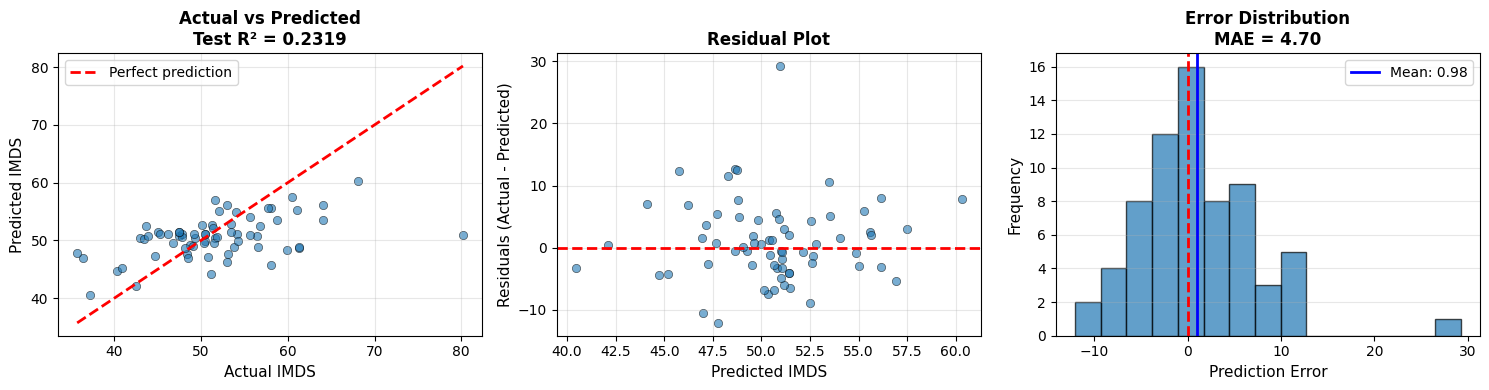

In [16]:
# =============================================================================
# PREDICTION VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Actual vs Predicted
ax1 = axes[0]
ax1.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual IMDS', fontsize=11)
ax1.set_ylabel('Predicted IMDS', fontsize=11)
ax1.set_title(f'Actual vs Predicted\nTest R² = {test_r2:.4f}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2 = axes[1]
ax2.scatter(y_test_pred, test_errors, alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted IMDS', fontsize=11)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Error Distribution
ax3 = axes[2]
ax3.hist(test_errors, bins=15, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.axvline(x=test_errors.mean(), color='blue', linestyle='-', lw=2,
            label=f'Mean: {test_errors.mean():.2f}')
ax3.set_xlabel('Prediction Error', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title(f'Error Distribution\nMAE = {test_mae:.2f}', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

Random Forest provides **feature importances** based on how much each feature contributes to reducing prediction error across all trees. This helps us understand which satellite embedding dimensions are most informative for predicting IMDS.

In [17]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

# Get feature importances from the trained model
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Calculate cumulative importance
cumsum = np.cumsum(importances[indices])
n_features_80 = np.argmax(cumsum >= 0.80) + 1

print("TOP 15 MOST IMPORTANT FEATURES")
print("="*50)
print(f"{'Rank':<6} {'Feature':<10} {'Importance':<12} {'Cumulative'}")
print("-"*50)

cumulative = 0
for i in range(15):
    idx = indices[i]
    cumulative += importances[idx]
    print(f"{i+1:<6} {embedding_cols[idx]:<10} {importances[idx]:.4f}       {cumulative*100:.1f}%")

print("-"*50)
print(f"\nFeatures needed for 80% importance: {n_features_80}/64 ({n_features_80/64*100:.1f}%)")

TOP 15 MOST IMPORTANT FEATURES
Rank   Feature    Importance   Cumulative
--------------------------------------------------
1      A30        0.1636       16.4%
2      A59        0.0644       22.8%
3      A13        0.0483       27.6%
4      A26        0.0479       32.4%
5      A33        0.0306       35.5%
6      A63        0.0255       38.0%
7      A42        0.0253       40.6%
8      A50        0.0226       42.8%
9      A20        0.0223       45.1%
10     A21        0.0201       47.1%
11     A48        0.0193       49.0%
12     A29        0.0184       50.8%
13     A43        0.0165       52.5%
14     A58        0.0158       54.1%
15     A36        0.0155       55.6%
--------------------------------------------------

Features needed for 80% importance: 35/64 (54.7%)


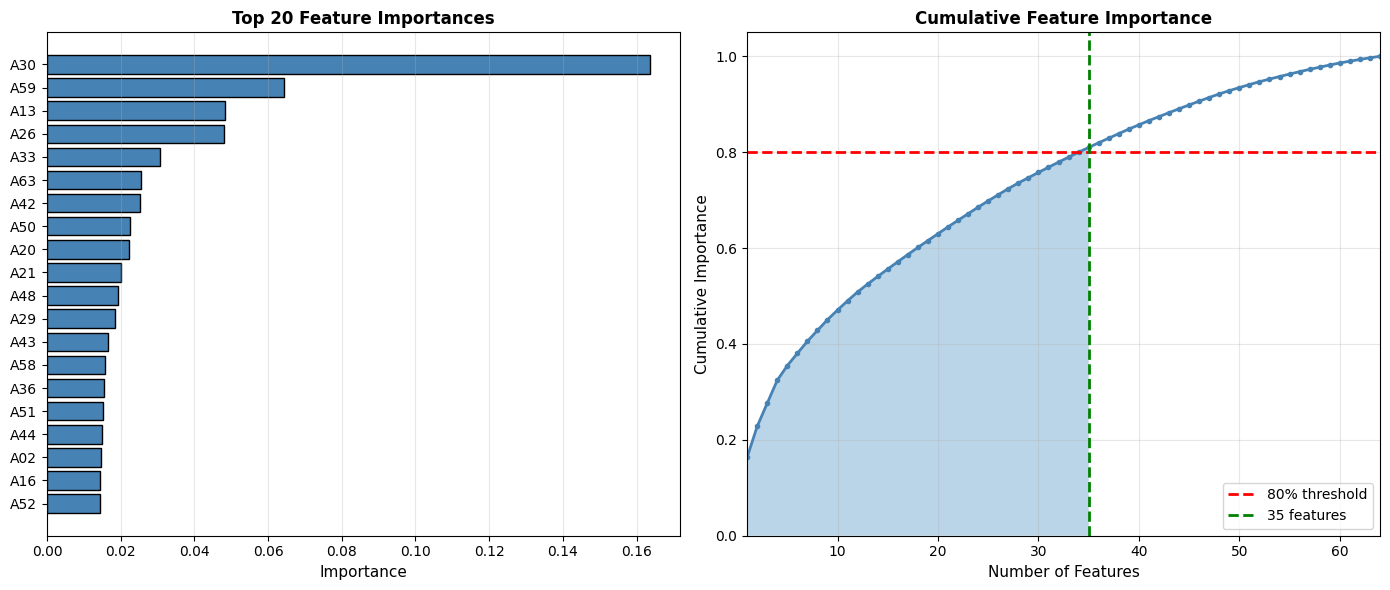

In [18]:
# =============================================================================
# FEATURE IMPORTANCE VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Top 20 Feature Importances
ax1 = axes[0]
top_n = 20
top_indices = indices[:top_n]
top_features = [embedding_cols[i] for i in top_indices]
top_importances = importances[top_indices]

ax1.barh(range(top_n), top_importances, edgecolor='black', color='steelblue')
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features)
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Cumulative Importance
ax2 = axes[1]
ax2.plot(range(1, 65), cumsum, linewidth=2, marker='o', markersize=3, color='steelblue')
ax2.axhline(y=0.8, color='r', linestyle='--', lw=2, label='80% threshold')
ax2.axvline(x=n_features_80, color='g', linestyle='--', lw=2, label=f'{n_features_80} features')
ax2.fill_between(range(1, n_features_80+1), cumsum[:n_features_80], alpha=0.3)
ax2.set_xlabel('Number of Features', fontsize=11)
ax2.set_ylabel('Cumulative Importance', fontsize=11)
ax2.set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 64)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## 11. Prediction Error Analysis

Understanding where the model makes large errors helps identify:
- **Systematic biases** (e.g., urban vs rural)
- **Challenging cases** that may need additional features
- **Potential data quality issues**

In [19]:
# =============================================================================
# CREATE RESULTS DATAFRAME
# =============================================================================

# Create dataframe with test set results
test_results = df_clean.iloc[idx_test].copy()
test_results['imds_actual'] = y_test
test_results['imds_predicted'] = y_test_pred
test_results['error'] = test_errors
test_results['abs_error'] = np.abs(test_errors)

In [20]:
# =============================================================================
# OVERPREDICTED MUNICIPALITIES
# =============================================================================
# These municipalities have LOWER actual IMDS than the model predicts.
# The model thinks they should be more developed based on satellite features.

overpredicted = test_results.nsmallest(10, 'error')

print("TOP 10 OVERPREDICTED MUNICIPALITIES")
print("(Model predicts HIGHER development than actual)")
print("="*70)

for _, row in overpredicted.iterrows():
    print(f"\n  {row['mun']}, {row['dep']}")
    print(f"    Actual: {row['imds_actual']:.2f} | Predicted: {row['imds_predicted']:.2f} | Error: {row['error']:.2f}")

TOP 10 OVERPREDICTED MUNICIPALITIES
(Model predicts HIGHER development than actual)

  Poroma, Chuquisaca
    Actual: 35.70 | Predicted: 47.79 | Error: -12.09

  Tinguipaya, Potosí
    Actual: 36.40 | Predicted: 46.97 | Error: -10.57

  Ayata, La Paz
    Actual: 43.60 | Predicted: 52.50 | Error: -8.90

  El Choro, Oruro
    Actual: 42.90 | Predicted: 50.36 | Error: -7.46

  Loreto, Beni
    Actual: 43.90 | Predicted: 50.67 | Error: -6.77

  Aucapata, La Paz
    Actual: 43.40 | Predicted: 50.16 | Error: -6.76

  Puerto Pérez, La Paz
    Actual: 45.00 | Predicted: 51.46 | Error: -6.46

  Cruz de Machacamarca, Oruro
    Actual: 45.20 | Predicted: 51.14 | Error: -5.94

  Carmen Rivero Tórrez, Santa Cruz
    Actual: 51.60 | Predicted: 56.92 | Error: -5.32

  Calacoto, La Paz
    Actual: 46.20 | Predicted: 51.03 | Error: -4.83


In [21]:
# =============================================================================
# UNDERPREDICTED MUNICIPALITIES
# =============================================================================
# These municipalities have HIGHER actual IMDS than the model predicts.
# They achieve better development than their satellite features suggest.

underpredicted = test_results.nlargest(10, 'error')

print("TOP 10 UNDERPREDICTED MUNICIPALITIES")
print("(Model predicts LOWER development than actual)")
print("="*70)

for _, row in underpredicted.iterrows():
    print(f"\n  {row['mun']}, {row['dep']}")
    print(f"    Actual: {row['imds_actual']:.2f} | Predicted: {row['imds_predicted']:.2f} | Error: {row['error']:.2f}")

TOP 10 UNDERPREDICTED MUNICIPALITIES
(Model predicts LOWER development than actual)

  La Paz, La Paz
    Actual: 80.20 | Predicted: 50.96 | Error: 29.24

  Huachacalla, Oruro
    Actual: 61.30 | Predicted: 48.64 | Error: 12.66

  Trinidad, Beni
    Actual: 61.30 | Predicted: 48.76 | Error: 12.54

  Llallagua, Potosí
    Actual: 58.10 | Predicted: 45.78 | Error: 12.32

  Tupiza, Potosí
    Actual: 59.90 | Predicted: 48.29 | Error: 11.61

  Vinto, Cochabamba
    Actual: 64.00 | Predicted: 53.47 | Error: 10.53

  Santa Cruz de la Sierra, Santa Cruz
    Actual: 64.10 | Predicted: 56.17 | Error: 7.93

  Colcapirhua, Cochabamba
    Actual: 68.10 | Predicted: 60.31 | Error: 7.79

  Atocha, Potosí
    Actual: 56.50 | Predicted: 48.79 | Error: 7.71

  Uncía, Potosí
    Actual: 51.10 | Predicted: 44.12 | Error: 6.98


In [22]:
# =============================================================================
# ERROR ANALYSIS BY DEPARTMENT
# =============================================================================

dept_errors = test_results.groupby('dep').agg({
    'error': ['mean', 'std', 'count'],
    'abs_error': 'mean'
}).round(2)

dept_errors.columns = ['Mean Error', 'Std Error', 'Count', 'Mean Abs Error']
dept_errors = dept_errors.sort_values('Mean Error')

print("\nPREDICTION ERRORS BY DEPARTMENT")
print("="*60)
print(dept_errors.to_string())
print("\nPositive error = Underpredicted (actual > predicted)")
print("Negative error = Overpredicted (actual < predicted)")


PREDICTION ERRORS BY DEPARTMENT
            Mean Error  Std Error  Count  Mean Abs Error
dep                                                     
Chuquisaca       -1.42       8.45      4            6.64
Pando            -1.37       4.14      2            2.93
Oruro            -0.14       6.08      8            3.97
La Paz            0.17       7.98     19            4.48
Santa Cruz        0.22       4.29     10            3.44
Potosí            2.26       6.73     13            5.78
Tarija            3.02       2.05      2            3.02
Cochabamba        3.48       4.56      7            4.40
Beni              3.58       9.73      3            8.09

Positive error = Underpredicted (actual > predicted)
Negative error = Overpredicted (actual < predicted)


## 12. Comparison: Baseline vs Optuna-Tuned Model

Let's compare our Optuna-tuned model with the baseline model that used fixed hyperparameters.

In [23]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================

# Baseline model parameters (from predict_imds_rf.ipynb)
baseline_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}

# Train baseline model for comparison
baseline_model = RandomForestRegressor(
    **baseline_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
baseline_model.fit(X_train_val, y_train_val)
baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print("MODEL COMPARISON: BASELINE vs OPTUNA-TUNED")
print("="*60)
print(f"\n{'Metric':<20} {'Baseline':<20} {'Optuna-Tuned':<20}")
print("-"*60)
print(f"{'Test R²':<20} {baseline_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'Test MAE':<20} {baseline_mae:<20.4f} {test_mae:<20.4f}")
print("-"*60)

# Calculate improvement
r2_improvement = (test_r2 - baseline_r2) / baseline_r2 * 100 if baseline_r2 != 0 else 0
mae_improvement = (baseline_mae - test_mae) / baseline_mae * 100

print(f"\nPerformance Change:")
print(f"  R² change:  {r2_improvement:+.1f}%")
print(f"  MAE change: {mae_improvement:+.1f}% (negative = improvement)")

MODEL COMPARISON: BASELINE vs OPTUNA-TUNED

Metric               Baseline             Optuna-Tuned        
------------------------------------------------------------
Test R²              0.2284               0.2319              
Test MAE             4.7516               4.7042              
------------------------------------------------------------

Performance Change:
  R² change:  +1.5%
  MAE change: +1.0% (negative = improvement)


In [24]:
# =============================================================================
# HYPERPARAMETER COMPARISON TABLE
# =============================================================================

print("\nHYPERPARAMETER COMPARISON")
print("="*60)
print(f"\n{'Parameter':<20} {'Baseline':<20} {'Optuna-Tuned':<20}")
print("-"*60)

for param in baseline_params.keys():
    baseline_val = baseline_params[param]
    optuna_val = best_params[param]
    print(f"{param:<20} {str(baseline_val):<20} {str(optuna_val):<20}")

print("-"*60)


HYPERPARAMETER COMPARISON

Parameter            Baseline             Optuna-Tuned        
------------------------------------------------------------
n_estimators         100                  150                 
max_depth            20                   23                  
min_samples_split    5                    3                   
min_samples_leaf     2                    4                   
max_features         sqrt                 None                
------------------------------------------------------------


## 13. Summary and Conclusions

### What We Learned

1. **Hyperparameter tuning with Optuna** provides a systematic, efficient way to find optimal model configurations

2. **Key hyperparameters** identified through importance analysis show which parameters have the most impact on model performance

3. **Prediction patterns** reveal systematic biases (urban vs rural) that satellite features don't fully capture

### Limitations to Consider

- **IMDS is a composite index** combining many dimensions not directly observable from satellite imagery
- **Sample size (339 municipalities)** limits the complexity of models we can train
- **Hyperparameter tuning can't overcome fundamental feature limitations** - we need the right features first

### Next Steps for Further Improvement

1. **Feature engineering**: Create new features from existing embeddings (ratios, PCA components)
2. **Additional data sources**: Incorporate night-time lights, land cover, or other satellite products
3. **Ensemble methods**: Combine multiple models (XGBoost, LightGBM, Neural Networks)
4. **Spatial features**: Include geographic coordinates or neighbor information

In [25]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("="*70)
print("FINAL SUMMARY: IMDS PREDICTION WITH OPTUNA HYPERPARAMETER TUNING")
print("="*70)

print(f"""
OPTIMIZATION DETAILS:
  • Trials completed: {N_TRIALS}
  • Best CV R² found: {best_trial.value:.4f}
  • Optimization method: TPE (Tree-structured Parzen Estimator)

BEST HYPERPARAMETERS:
  • n_estimators: {best_params['n_estimators']}
  • max_depth: {best_params['max_depth']}
  • min_samples_split: {best_params['min_samples_split']}
  • min_samples_leaf: {best_params['min_samples_leaf']}
  • max_features: {best_params['max_features']}

FINAL MODEL PERFORMANCE:
  • Test R² Score: {test_r2:.4f}
  • Test RMSE: {test_rmse:.4f} IMDS points
  • Test MAE: {test_mae:.4f} IMDS points

FEATURE IMPORTANCE:
  • Features for 80% importance: {n_features_80}/64 ({n_features_80/64*100:.1f}%)
  • Top 3 features: {', '.join([embedding_cols[i] for i in indices[:3]])}
""")

print("="*70)

FINAL SUMMARY: IMDS PREDICTION WITH OPTUNA HYPERPARAMETER TUNING

OPTIMIZATION DETAILS:
  • Trials completed: 100
  • Best CV R² found: 0.2380
  • Optimization method: TPE (Tree-structured Parzen Estimator)

BEST HYPERPARAMETERS:
  • n_estimators: 150
  • max_depth: 23
  • min_samples_split: 3
  • min_samples_leaf: 4
  • max_features: None

FINAL MODEL PERFORMANCE:
  • Test R² Score: 0.2319
  • Test RMSE: 6.5138 IMDS points
  • Test MAE: 4.7042 IMDS points

FEATURE IMPORTANCE:
  • Features for 80% importance: 35/64 (54.7%)
  • Top 3 features: A30, A59, A13



---

## Exercises for Students

### Exercise 1: Modify the Search Space
Try expanding or narrowing the search space for `n_estimators` and `max_depth`. How does this affect the optimization results?

### Exercise 2: Different Samplers
Replace `TPESampler` with `RandomSampler` and compare the optimization efficiency. How many trials does each take to find good parameters?

### Exercise 3: Add Pruning
Implement early stopping (pruning) to terminate unpromising trials. Use `optuna.pruners.MedianPruner` and integrate it with cross-validation.

### Exercise 4: Multi-Objective Optimization
Modify the objective to optimize both R² (maximize) and training time (minimize). This is a multi-objective optimization problem.

### Exercise 5: Different Models
Apply the same Optuna framework to a Gradient Boosting model (`GradientBoostingRegressor` or `XGBRegressor`). Compare results with Random Forest.

---

## References

- **Optuna Documentation**: https://optuna.readthedocs.io/
- **Akiba et al. (2019)**: Optuna: A Next-generation Hyperparameter Optimization Framework. KDD 2019.
- **DS4Bolivia Repository**: https://github.com/quarcs-lab/ds4bolivia
- **scikit-learn Random Forest**: https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees